#  Imitation Learning & Offline RL
*NB: Обучение на основе демонстраций (лекция 11).*

Данное домашнее задание является продолжением семинара по Imitation Learning и Offline RL. Здесь мы будем переиспользовать наработки из семинара, а также приведенные в нем датасеты (*NB: далее в тетрадке все необходимое приведено!*).

---

На семинаре обсуждался метод Behavior Cloning (BC), который представляет собой подход к обучению моделей на основе пар “состояние-действие”, полученных от эксперта.

Главное преимущество этого метода заключается в его простоте реализации. Однако у него есть два существенных недостатка:

1. Накопление ошибок в ходе одного эпизода
2. Сдвиг распределения состояний между обучающей и тестовой выборками — в результате обучения BC агент может предпочитать состояния, которые слабо представлены в экспертном датасете, следовательно точность экспертного решения может быть недостаточной.

**Датасет** $\mathcal{D} = \{ (s, a, r, s')\}$ собран с помощью неизвестной **экспертной стратегии** $\pi_e(a | s)$. $s$ - состояние, $r$ - вознаграждение, $a$ - действие, $s'$ - следующее состояние. $s \sim d^\pi$ -- множество состояний в памяти.

Цель: $\max_\pi \sum\limits_{t=0}^T \mathbb{E}_{s_t \sim d^\pi, a_t \sim \pi(a | s)} \left[\gamma^t r(s_t, a_t)\right]$

## DAgger (Dataset Aggregation)

[Статья](https://arxiv.org/abs/1011.0686).

Задача: см. соотв. секцию в конце.

Идея метода: собирать дополнительные экспертные данные во время обучения.

Обозначения: $\pi_a$ -- стратегия обучаемого агента, $\pi_e$ -- стратегия эксперта, $\mathcal{D}_e$ -- данные с эксперта, $M$ -- количество дополнительных данных.

Алгоритм:
1. Собрать новые данные $ \{ s_i \}_{i=0}^M$ с помощью **текущей** стратегии $\pi_a$. *NB: в полученных траекториях нас интересуют только состояния.*
2. Для собранного набора состояний опросить эксперта $\pi_e$, какие действия выбрал бы он. В результате получен новый экспертный датасет $\mathcal{D}_a = \{(s_i, a_i)\}_{i=0}^M$.
3. Провести итерацию обучения агента $\pi_a$ на расширенном наборе данных $\mathcal{D} = \mathcal{D}_e \cup \mathcal{D}_a$.
4. Повторить.

Таким образом, метод BC (behavior cloning) надо дополнить только итеративным способом обновления датасета.

Основные особенности метода:
- Помогает избежать накопления ошибок, возникающих при чистом копировании поведения (behavior cloning).
- Охватывает те состояния, в которые агент действительно попадает во время выполнения задачи, что улучшает обобщающую способность модели.
- Сводит задачу imitation learning к no-regret online learning. При разумных условиях DAgger гарантирует, что стратегия агента будет работать почти так же хорошо, как стратегия эксперта.

Основные особенности/требования метода:
- есть доступ к среде;
- есть доступ к эксперту.

### Код
Что взять за основу:
- `BCAgent`,
- в качестве эксперта модель `SACAgent`, веса модели `expert.pt`.

Что потребуется изменить:
- метод `train`;
- `ReplayBuffer`.

Параметры:
- $M$ -- количество данных за один update.
- $k_e : k_a$ -- пропорция, сколько в батче экспертных данных к данным с агента (обычно $1 : 1$).

Что можно попробовать:
- фильтровать новые траектории, с которых будут взяты данные в $\mathcal{D}_a$.
- изменять пропорцию $k_e : k_a$. В начале в основном обучаться на экспертных данных.
- для сбора датасета использовать микс распределений текущей и экспертной стратегий с помощью линейной интерполяции: $\pi = \alpha \pi_e + (1-\alpha)\pi_a$. Начинать обучение с полностью экспертной стратегии и постепенно "переносить вес" на обученную стратегию, т.е. стартовать с $\alpha = 1.0$ и в процессе обучения снижать $\alpha \rightarrow 0$.

## SQIL (Soft Q Imitation Learning)

[Статья](https://arxiv.org/abs/1905.11108).

Задача: см. соотв. секцию в конце.

Идея метода: SQIL преобразует задачу имитационного обучения в задачу обучения с подкреплением за счет введения специальной функции вознаграждения. Вместо того чтобы строить специальную функцию потерь для имитации (как в behavior cloning или DAgger), в SQIL:
- Переходам из экспертных демонстраций назначается фиксированная положительная награда (например, +1).
- Переходам агента, полученным в ходе его собственной активности, назначается значительно меньшая или нулевая награда.

Агент обучается с помощью обычного off-policy алгоритма обучения с подкреплением (DQN, SAC и тп), используя модифицированную функцию награды.
В результате агент стремится повторять поведение эксперта, потому что именно оно приводит к получению большей награды.

Обозначения: $\pi_a$ -- стратегия обучаемого агента, $\pi_e$ -- стратегия эксперта, $\mathcal{D}_e$ -- данные с эксперта.

Алгоритм:
1. Переходам из экспертного датасета $\mathcal{D}_e = \{(s_i, a_i, s'_i)\}_{i=0}^N$ назначается вознаграждение $r = 1$.
2. Инициализируется ReplayBuffer: $\mathcal{D} = \mathcal{D}_e$.
3. Проводится раунд сбора новых траекторий $\mathcal{D}_a = \{(s_i, a_i, s'_i)\}_{i=0}^M$ на основе **текущей** стратегии $\pi_a$. Собранным траекториям назначается вознаграждение $r = 0$.
3. Собранные данные добавляются в ReplayBuffer: $\mathcal{D} = \mathcal{D} \cup \mathcal{D}_a$.
4. Проводится раунд обучения $\pi_a$ на ReplayBuffer.
5. Повторить с 3.  

Таким образом, для метода SAC (soft actor-critic) надо изменить ReplayBuffer.

Основные особенности метода:
- Специальная функция награды;
- Можно использовать любой стандартный off-policy алгоритм RL без модификаций;
- Неявная имитация: агента не заставляют напрямую копировать эксперта — он сам стремится к стратегии, приносящей наибольшую отдачу.
- Используется преимущество off-policy RL над имитационным обученим: агент, потенциально, может оптимизировать поведение эксперта.

### Код
Что взять за основу:
- `SACAgent`;

Что потребуется изменить:
- `ReplayBuffer`;
- метод `train`.

Параметры:
- $k_e : k_a$ -- пропорция, сколько в батче экспертных данных к данным с агента (обычно $1 : 1$). *NB: для этого потребуется хранить данные отдельно друг от друга.*

# Задание

1. Реализовать методы DAgger и SQIL.
2. Сравнить три метода BC, DAgger и SQIL на трех заданиях в среде `PointMaze` (конфигурацию заданий см. ниже).
3. [Optional] Изменить ReplayBuffer:
 - формировать батч таким образом, чтобы за одну эпоху последовательно и без повторений использовался каждый элемент датасета (1 эпоха = 1 раз пройти по всему датасету). Выводить число эпох.
3. В отчете показать несколько графиков:
 - во время обучения -- график SR (процент успешно завершенных эпизодов при evaluate);
 - после обучения -- траектория движения обученного агента, SR при тестировании агента `n` раз на задании.
4. В отчёте должны быть ссылки на проекты (public доступ) в WandB с логированием метрик экспериментов. По названию Run'а должно быть понятно, к какому эксперименту он относится, например: `task1_BC`, `task2_SQIL` и т.д.. Также в отчёте должен быть параграф с анализом результатов.



# Код

## Установка зависимостей для colab

In [ ]:
try:
    import google.colab
    COLAB = True
    if COLAB:
        !pip -q install piglet
        !pip -q install imageio_ffmpeg
        !pip -q install moviepy==1.0.3
        !pip install gymnasium[mujoco]
        !pip install gymnasium_robotics
        !pip install h5py
except:
    COLAB = False

NEED_DRIVE = True
HAS_DRIVE = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 48.2 MB/s eta 0:00:00
  Attempting uninstall: mujoco
    Found existing installation: mujoco 3.3.0
    Uninstalling mujoco-3.3.0:
      Successfully uninstalled mujoco-3.3.0


In [ ]:
if NEED_DRIVE and COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    HAS_DRIVE = True

https://drive.google.com/file/d/1ODvl6a4N7Jw8Q-qF-zof8nLY1gMk1x3i/view?usp=drive_link

In [ ]:
!wget -O "data_umaze_bad.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1t_aAlPjniYUYL63CryEmhEJUyWkQBdCB&export=download&authuser=0"
!wget -O "data_umaze_good.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1hw5pbbyPUcffmVKM1FMdaDR93nEuqqsu&export=download&authuser=0"
!wget -O "data_umaze_corner.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1NqM7Xa6KKX6FCJNFaaxEKb2moRlU4Dg8&export=download&authuser=0"
!wget -O "data_corner.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1ODvl6a4N7Jw8Q-qF-zof8nLY1gMk1x3i&export=download&authuser=0"
!wget -O "data_line.hdf5" --no-check-certificate "https://drive.usercontent.google.com/download?id=1FdGp66Ef8k2fkSdTghkoPti_NoGcOjSD&export=download&authuser=0"
!wget -O "expert_Umaze.pt" --no-check-certificate "https://drive.usercontent.google.com/download?id=1daCX0dxBmAPtBAXAvk6s_BeSkndIBHLP&export=download&authuser=0"
!wget -O "expert_medium.pt" --no-check-certificate "https://drive.usercontent.google.com/download?id=14g2motZ8KA_iUDcP_TSFjZFrZ4Zpe-6-&export=download&authuser=0"

--2025-04-07 17:15:37--  https://drive.usercontent.google.com/download?id=1t_aAlPjniYUYL63CryEmhEJUyWkQBdCB&export=download&authuser=0
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56506808 (54M) [application/octet-stream]
Saving to: ‘data_umaze_bad.hdf5’

data_umaze_bad.hdf5 100%[===================>]  53.89M  38.1MB/s    in 1.4s    

2025-04-07 17:15:43 (38.1 MB/s) - ‘data_umaze_bad.hdf5’ saved [56506808/56506808]

--2025-04-07 17:15:43--  https://drive.usercontent.google.com/download?id=1hw5pbbyPUcffmVKM1FMdaDR93nEuqqsu&export=download&authuser=0
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.

In [ ]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from dataclasses import dataclass

import os
import random
import time
import h5py

import numpy as np
import gymnasium as gym
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from IPython.display import Image

TensorBatch = List[torch.Tensor]

try:
    import wandb
    WANDB_IS_AVAILABLE = True
except ImportError:
    WANDB_IS_AVAILABLE = False

# os.environ["WANDB_API_KEY"] = "your wandb-api key"
os.environ["WANDB_API_KEY"] = "2493ada22b975bf0409f8240f642b7711e61be40"

## Среда



PointMaze

Среда для экспериментов: [**PointMaze**](https://robotics.farama.org/envs/maze/point_maze/).

Задача поиска пути в лабиринте:
- расположение препятствия фиксированное
- начальная точка и точка цели задается в заранее определенной области
- агент достиг своей цели, если расстояние между ним и целью < 0.5
- конец эпизода: агент достиг своей цели или превышено число допустимых шагов в среде
- награда: 1, если агент достиг цели
- наблюдения: координаты агента, скорость агента, координаты цели $$obs = [x_a, y_a, v_x, v_y, x_g, y_g]$$
- действие: линейная сила $$action = [F_x, F_y]$$
- метрика: $SR = \frac{success}{n_{ep}}$ -- процент успешно завершенных эпизодов. Агент решает задачу поиска пути от начальной точки до точки цели $n_{ep}$ раз. $success$ -- сколько раз цель была достигнута.


In [ ]:
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)


class PointMazeArrayObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Формируется векторное наблюдение из словаря
        self._obs_keys = ["observation", "desired_goal"]
        new_obs_len = np.sum(
            [self.observation_space[k].shape[0] for k in self._obs_keys]
        )
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(new_obs_len,), dtype=np.float32
        )

    def observation(self, obs):
        array_obs = np.concatenate([obs[key].flatten() for key in self._obs_keys])
        return array_obs


Создание среды

In [ ]:
# 'r' -- возможная начальная точка для агента, 'g' -- возможная целевая точка,
# 'c' -- начальная или целевая точка
TRAIN_MAP = [
    [1, 1, 1, 1, 1],
    [1, 0, "r", 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, "g", 0, 1],
    [1, 1, 1, 1, 1],
]

pic_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

def make_env(seed):
    def thunk():
        env = gym.make(
            "PointMaze_UMaze-v3",
            max_episode_steps=200,
            maze_map=TRAIN_MAP,
            continuing_task=False,
        )
        env = PointMazeArrayObservationWrapper(env)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

Отрисовка траекторий

In [ ]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_walls(walls):
    (height, width) = walls.shape
    for i, j in zip(*np.where(walls)):
        x = np.array([j, j + 1]) -width/2
        y0 = np.array([i, i]) -height/2
        y1 = np.array([i + 1, i + 1]) -height/2
        plt.fill_between(x, y0, y1, color="grey")
    plt.xticks([])
    plt.yticks([])

def plot_all_trajectories( walls=None, trajectories_=None, traj_filepath='output.png'):
    plt.clf()
    if walls  is not None:
        plot_walls(walls)
    if trajectories_ is not None:
        all_points = trajectories_
        sns.kdeplot(x=all_points[:, 0], y=all_points[:, 1], cmap='viridis', fill=True, alpha=0.5)
    plt.savefig(traj_filepath)

def plot_start_and_end_points(points, traj_filepath="start_and_end.png"):
    plt.clf()
    plt.scatter(
        points[:, 0],
        points[:, 1],
        marker=".",
        color="red",
        s=200,
        label="start",
    )
    plt.scatter(
        points[:, 2],
        points[:, 3],
        marker=".",
        color="green",
        s=200,
        label="end",
    )
    plt.savefig(traj_filepath)


def plot_one_trajectory(obs_vec, goal=None, walls=None, traj_filepath='output.png'):
    plt.clf()
    if walls  is not None:
        plot_walls(walls)

    if (obs_vec is not None):
        obs_vec = np.array(obs_vec)
        plt.plot(obs_vec[:, 0], obs_vec[:, 1], ".", alpha=0.3)
        plt.scatter(
            [obs_vec[0, 0]],
            [obs_vec[0, 1]],
            marker="+",
            color="red",
            s=200,
            label="start",
        )
        plt.scatter(
            [obs_vec[-1, 0]],
            [obs_vec[-1, 1]],
            marker="+",
            color="green",
            s=200,
            label="end",
        )
        if (goal is not None):
            plt.scatter(
                goal[:,0], goal[:,1], marker="*", color="green", s=200, label="goal"
            )
    plt.savefig(traj_filepath)


Тестирование агента

In [ ]:
@dataclass
class EnvConfig:
    num_eval_episodes: int = 10
    eval_seed: int = 10

class Evaluate:
    def __init__(self, make_env, config):
        self.num_episodes = config.num_eval_episodes
        self.seed = config.eval_seed
        self.env = make_env(self.seed)()
        self.map_ = pic_map
        self.map_ = np.array(self.map_)

    def eval_actor(self, actor):
        actor.eval()
        success = []
        for _ in range(self.num_episodes):
            state, info = self.env.reset()
            done, tr = False, False
            while not (done or tr):
                action = actor.get_action(state)
                state, reward, done, tr, info = self.env.step(action)
            if "success" in info:
                success.append(info["success"])
            else:
                success.append(info["episode"]["r"])

        actor.train()
        return np.asarray(success).mean()

    def eval_tr(self, actor, num_episodes=1, traj_filepath='output.png'):
        actor.eval()
        success = []
        observations = []
        for _ in range(num_episodes):
            state, info = self.env.reset()
            observations.append(state)
            done, tr = False, False
            while not (done or tr):
                action = actor.get_action(state)
                state, reward, done, tr, info = self.env.step(action)
                observations.append(state)
            if "success" in info:
                success.append(info["success"])
            else:
                success.append(info["episode"]["r"])

        actor.train()
        print(f"SR: {np.asarray(success).mean()}")
        plot_one_trajectory(observations, traj_filepath=traj_filepath, walls = self.map_)

## Методы

### Общее

In [ ]:
class ReplayBuffer:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        buffer_size: int,
        device: str = "cpu",
        config=None,
    ):
        self._buffer_size = buffer_size
        self._pointer = 0
        self._size = 0
        self._config = config

        self._states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._actions = torch.zeros(
            (buffer_size, action_dim), dtype=torch.float32, device=device
        )
        self._rewards = torch.zeros(
            (buffer_size, 1), dtype=torch.float32, device=device
        )
        self._next_states = torch.zeros(
            (buffer_size, state_dim), dtype=torch.float32, device=device
        )
        self._dones = torch.zeros((buffer_size, 1), dtype=torch.float32, device=device)
        self._device = device

    def _to_tensor(self, data: np.ndarray) -> torch.Tensor:
        return torch.tensor(data, dtype=torch.float32, device=self._device)

    def load_dataset_from_file(self, path: str, with_goal: bool):
        data = dict()
        with h5py.File(path, "r") as f:
            for key in f.keys():
                if key == "infos":
                    for info_key in f[key].keys():
                        data[info_key] = f.get(key)[info_key][:]
                    continue
                data[key] = f.get(key)[:]
        return data

    def load_dataset(self, data: Dict[str, np.ndarray]):
        # Для offline методов: загрузка датасета
        if self._size != 0:
            raise ValueError("Trying to load data into non-empty replay buffer")
        n_transitions = data["observations"].shape[0]
        if n_transitions > self._buffer_size:
            raise ValueError(
                "Replay buffer is smaller than the dataset you are trying to load!"
            )
        self._states[:n_transitions] = self._to_tensor(data["observations"])
        self._actions[:n_transitions] = self._to_tensor(data["actions"])
        self._rewards[:n_transitions] = self._to_tensor(data["rewards"][..., None])
        self._next_states[:n_transitions] = self._to_tensor(data["next_observations"])
        self._dones[:n_transitions] = self._to_tensor(data["terminals"][..., None])
        self._size += n_transitions
        self._pointer = min(self._size, n_transitions)

        print(f"Dataset size: {n_transitions}")

    def sample(self, batch_size: int) -> TensorBatch:
        indices = np.random.randint(0, self._size, size=batch_size)
        states = self._states[indices]
        actions = self._actions[indices]
        rewards = self._rewards[indices]
        next_states = self._next_states[indices]
        dones = self._dones[indices]
        return [states, actions, rewards, next_states, dones]

    def add_transition(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        # Для off-policy методов: добавление данных при взаимодействии агента со средой
        self._states[self._pointer] = self._to_tensor(state)
        self._actions[self._pointer] = self._to_tensor(action)
        self._rewards[self._pointer] = self._to_tensor(reward)
        self._next_states[self._pointer] = self._to_tensor(next_state)
        self._dones[self._pointer] = self._to_tensor(done)

        self._pointer = (self._pointer + 1) % self._buffer_size
        self._size = min(self._size + 1, self._buffer_size)


In [ ]:
class Logger:
    def __init__(self, args):
        run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
        if args.track:
            import wandb

            self.run = wandb.init(
                project=args.wandb_project_name,
                entity=args.wandb_entity,
                sync_tensorboard=True,
                config=vars(args),
                name=run_name,
                monitor_gym=True,
                save_code=True,
            )
        else:
            self.run = None
        self.writer = SummaryWriter(f"runs/{run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s"
            % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
        )

    def init_time(self):
        self.start_time = time.time()

    def log_metric(self, metric_dict: dict, global_step: int):
        for key, item in metric_dict.items():
            self.writer.add_scalar(key, item, global_step)

    def time_step(self, global_step):
        if global_step % 100 == 0:
            print("SPS:", int(global_step / (time.time() - self.start_time)))
            self.log_metric(
                {"charts/SPS": int(global_step / (time.time() - self.start_time))},
                global_step,
            )

    def close(self):
        self.writer.close()
        if self.run:
            self.run.finish()


In [ ]:
def train_offpolicy(env, agent, rb, config, logger, eval_):
    if config.checkpoints_path is not None:
        print(f"Checkpoints path: {config.checkpoints_path}")
        os.makedirs(config.checkpoints_path, exist_ok=True)

    # start train
    obs, _ = env.reset(seed=config.seed)
    for global_step in range(config.total_timesteps):
        # выбор действий
        if global_step < config.learning_starts:
            actions = np.array(env.action_space.sample())
        else:
            actions = agent.get_action(obs)

        # выполнение действия в среде
        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        # логирование информации
        if terminations or truncations:
            if (infos is not None) and ("episode" in infos):
                print(
                    f"global_step={global_step}, episodic_return={infos['episode']['r']}"
                )
                metrics = {
                    "charts/episodic_return": infos["episode"]["r"],
                    "charts/episodic_length": infos["episode"]["l"],
                }
                if "success" in infos:
                    metrics["charts/success"] = infos["success"]
                logger.log_metric(metrics, global_step)

        # сохранение данных в ReplayBuffer
        real_next_obs = next_obs.copy()
        rb.add_transition(obs, actions, rewards, real_next_obs, terminations)

        if terminations or truncations:
            next_obs, _ = env.reset()
        obs = next_obs

        # обучение
        if global_step > config.learning_starts:
            data = rb.sample(config.batch_size)
            metrics = agent.update(data, global_step)

            # логгирование
            if global_step % config.eval_freq == 0:
                SR = eval_.eval_actor(agent)
                metrics["SR"] = SR
                logger.log_metric(metrics, global_step)
                logger.time_step(global_step)
                print(f"Step {global_step}: SR = {SR}")
                if config.checkpoints_path:
                    torch.save(
                        agent.state_dict(),
                        os.path.join(
                            config.checkpoints_path, f"checkpoint_{global_step}.pt"
                        ),
                    )


def train_offline(env, agent, rb, config, logger, eval_):
    if config.checkpoints_path is not None:
        print(f"Checkpoints path: {config.checkpoints_path}")
        os.makedirs(config.checkpoints_path, exist_ok=True)
    # данные загружаются в ReplayBuffer
    dataset = rb.load_dataset_from_file(path=config.data_path, with_goal=False)
    rb.load_dataset(dataset)

    # start train
    obs, _ = env.reset(seed=config.seed)
    for global_step in range(config.total_timesteps):
        # обучение
        data = rb.sample(config.batch_size)
        metrics = agent.update(data, global_step)

        # логгирование
        if global_step % config.eval_freq == 0:
            SR = eval_.eval_actor(agent)
            metrics["SR"] = SR
            logger.log_metric(metrics, global_step)
            logger.time_step(global_step)
            print(f"Step {global_step}: SR = {SR}")
            if config.checkpoints_path:
                torch.save(
                    agent.state_dict(),
                    os.path.join(
                        config.checkpoints_path, f"checkpoint_{global_step}.pt"
                    ),
                )


def train(config, Agent, ReplayBuffer, train_func, make_env):
    logger = Logger(config)

    # seeding
    random.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)
    torch.backends.cudnn.deterministic = config.torch_deterministic

    device = torch.device(
        "cuda" if torch.cuda.is_available() and config.cuda else "cpu"
    )

    # среда
    env = make_env(config.seed)()
    eval_ = Evaluate(make_env, config)

    observation_space_shape = env.observation_space.shape
    action_space = env.action_space
    env.observation_space.dtype = np.float32

    # агент
    agent = Agent(config, device, observation_space_shape, action_space)

    rb = ReplayBuffer(
        buffer_size=config.buffer_size,
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.shape[0],
        device=device,
        config=config,
    )

    logger.init_time()

    # обучение
    train_func(env, agent, rb, config, logger, eval_)

    env.close()
    logger.close()
    return agent

In [ ]:

LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor(nn.Module):
    def __init__(self, observation_space_shape, action_space):
        super().__init__()
        self.fc1 = nn.Linear(np.array(observation_space_shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (action_space.high - action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (action_space.high + action_space.low) / 2.0,
                dtype=torch.float32,
            ),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum()
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

class SoftQNetwork(nn.Module):
    def __init__(self, observation_space_shape, action_space):
        super().__init__()
        self.fc1 = nn.Linear(
            np.array(observation_space_shape).prod() + np.prod(action_space.shape),
            256,
        )
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

EXP_ADV_MAX = 100.0


class Squeeze(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.squeeze(dim=self.dim)


class MLP(nn.Module):
    def __init__(
        self,
        dims,
        activation_fn: Callable[[], nn.Module] = nn.ReLU,
        output_activation_fn: Callable[[], nn.Module] = None,
        squeeze_output: bool = False,
        dropout: Optional[float] = None,
    ):
        super().__init__()
        n_dims = len(dims)
        if n_dims < 2:
            raise ValueError("MLP requires at least two dims (input and output)")

        layers = []
        for i in range(n_dims - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(activation_fn())

            if dropout is not None:
                layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(dims[-2], dims[-1]))
        if output_activation_fn is not None:
            layers.append(output_activation_fn())
        if squeeze_output:
            if dims[-1] != 1:
                raise ValueError("Last dim must be 1 when squeezing")
            layers.append(Squeeze(-1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueFunction(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int = 256, n_hidden: int = 2):
        super().__init__()
        dims = [state_dim, *([hidden_dim] * n_hidden), 1]
        self.v = MLP(dims, squeeze_output=True)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.v(state)

In [ ]:
# Общая конфигурация для экспериментов
@dataclass
class ConfigExp:
    exp_name: str = "offline_rl"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = True
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "offline-rl-hw"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""

    env_id: str = "PointMaze_UMaze-v3"
    """the environment id of the task"""
    total_timesteps: int = 300000
    """total timesteps of the experiments"""
    num_envs: int = 1
    """the number of parallel game environments"""
    buffer_size: int = int(1e6)
    """the replay memory buffer size"""

    eval_freq: int = int(5e3)
    checkpoints_path: str = "model"
    eval_seed: int = 1024
    num_eval_episodes: int = 10

### Behavioral Cloning

In [ ]:
@dataclass
class ConfigBC(ConfigExp):
    batch_size: int = 1024
    policy_lr: float = 3e-4
    data_path: str = "/content/data_umaze_dense.hdf5"

In [ ]:
# data =
        #           obs: torch.Tensor,
        #           action: torch.Tensor,
        #           reward: torch.Tensor,
        #           next_obs: torch.Tensor,
        #           done: torch.Tensor,

class BCAgent(nn.Module):
    def __init__(self, cfg: ConfigBC, device, observation_space_shape, action_space):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.init_actor(observation_space_shape, action_space)

    def init_actor(self, observation_space_shape, action_space):
        self.actor = Actor(observation_space_shape, action_space).to(self.device)
        self.actor_optimizer = optim.Adam(
            list(self.actor.parameters()), lr=self.cfg.policy_lr
        )

    def update(
        self,
        data,
        global_step,
    ) -> dict:
        # update actor
        observations = data[0]
        action = data[1]

        pi, log_pi, _ = self.actor.get_action(observations)

        # actor_loss = ...
        ####### Код с семинара ########
        actor_loss = F.mse_loss(pi, action)
        ##############################

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        actor_metrics = {"losses/actor_loss": actor_loss.item()}
        return actor_metrics

    def get_action(self, observation: np.ndarray, epsilon: float = 0.0) -> int:
        actions, _, _ = self.actor.get_action(torch.Tensor(observation).to(self.device))
        actions = actions.detach().cpu().numpy()
        return actions

    def state_dict(self) -> Dict[str, Any]:
        return {
            "actor": self.actor.state_dict(),
            "actor_optim": self.actor_optimizer.state_dict(),
        }

    def load_state_dict(self, state_dict: Dict[str, Any]):
        self.actor.load_state_dict(state_dict=state_dict["actor"])
        self.actor_optimizer.load_state_dict(state_dict=state_dict["actor_optim"])


### SAC

In [ ]:
@dataclass
class ConfigSAC(ConfigExp):
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 0.005
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 1024
    """the batch size of sample from the reply memory"""
    learning_starts: int = 5e3
    """timestep to start learning"""
    policy_lr: float = 3e-4
    """the learning rate of the policy network optimizer"""
    q_lr: float = 1e-3
    """the learning rate of the Q network network optimizer"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    target_network_frequency: int = 1  # Denis Yarats' implementation delays this by 2.
    """the frequency of updates for the target nerworks"""
    alpha: float = 0.2
    """Entropy regularization coefficient."""
    autotune: bool = True
    """automatic tuning of the entropy coefficient"""

    data_path: str = "notebook/data_umaze_d.hdf5"

In [ ]:
class SACAgent(nn.Module):
    def __init__(self, cfg: ConfigSAC, device, observation_space_shape, action_space):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.init_actor_critic(observation_space_shape, action_space)

    def init_actor_critic(self, observation_space_shape, action_space):
        self.actor = Actor(observation_space_shape, action_space).to(self.device)
        self.qf1 = SoftQNetwork(observation_space_shape, action_space).to(self.device)
        self.qf2 = SoftQNetwork(observation_space_shape, action_space).to(self.device)
        self.qf1_target = SoftQNetwork(observation_space_shape, action_space).to(
            self.device
        )
        self.qf2_target = SoftQNetwork(observation_space_shape, action_space).to(
            self.device
        )
        self.qf1_target.load_state_dict(self.qf1.state_dict())
        self.qf2_target.load_state_dict(self.qf2.state_dict())
        self.q_optimizer = optim.Adam(
            list(self.qf1.parameters()) + list(self.qf2.parameters()), lr=self.cfg.q_lr
        )
        self.actor_optimizer = optim.Adam(
            list(self.actor.parameters()), lr=self.cfg.policy_lr
        )

        # Automatic entropy tuning
        if self.cfg.autotune:
            self.target_entropy = -torch.prod(
                torch.Tensor(action_space.shape).to(self.device)
            ).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha = self.log_alpha.exp().item()
            self.a_optimizer = optim.Adam([self.log_alpha], lr=self.cfg.q_lr)
        else:
            self.alpha = self.cfg.alpha

    def actor_loss(self, pi, log_pi, data):
        observations = data[0]
        # actor_loss = mean(- (Q' + a H))
        ####### Здесь ваш код ########
        qf1_pi = self.qf1(observations, pi)
        qf2_pi = self.qf2(observations, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        actor_loss = ((self.alpha * log_pi) - min_qf_pi).mean()
        ##############################
        return actor_loss

    def compute_critic_loss(
        self,
        data,
    ) -> Tuple[torch.Tensor, dict, dict]:
        observations, actions, rewards, next_observations, dones = data
        rewards = rewards.flatten()
        dones = dones.flatten()
        with torch.no_grad():
            next_state_actions, next_state_log_pi, _ = self.actor.get_action(
                next_observations
            )
            # для s', a' вычислить Q(s', a') с помощью уравнения Беллмана
            #         1) min_qf_next_target = Q' + a H
            #         2) next_q_value = Q(s', a') = r + (1 - d) * gamma * min_qf_next_target
            ####### Код с семинара ########
            qf1_next_target = self.qf1_target(next_observations, next_state_actions)
            qf2_next_target = self.qf2_target(next_observations, next_state_actions)
            min_qf_next_target = (
                torch.min(qf1_next_target, qf2_next_target)
                - self.alpha * next_state_log_pi
            )
            next_q_value = rewards + (1 - dones) * self.cfg.gamma * (min_qf_next_target).view(-1)
            ##############################

        qf1_a_values = self.qf1(observations, actions).view(-1)
        qf2_a_values = self.qf2(observations, actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss
        metrics = {
            "losses/qf1_values": qf1_a_values.mean().item(),
            "losses/qf2_values": qf2_a_values.mean().item(),
            "losses/qf1_loss": qf1_loss.item(),
            "losses/qf2_loss": qf2_loss.item(),
            "losses/qf_loss": qf_loss.item() / 2.0,
        }
        return qf_loss, metrics

    def update_critic(
        self,
        data,
    ) -> dict:
        qf_loss, metrics = self.compute_critic_loss(data)

        # optimize the model
        self.q_optimizer.zero_grad()
        qf_loss.backward()
        self.q_optimizer.step()

        return metrics

    def update_target_critic(self):
        for param, target_param in zip(
            self.qf1.parameters(), self.qf1_target.parameters()
        ):
            target_param.data.copy_(
                self.cfg.tau * param.data + (1 - self.cfg.tau) * target_param.data
            )
        for param, target_param in zip(
            self.qf2.parameters(), self.qf2_target.parameters()
        ):
            target_param.data.copy_(
                self.cfg.tau * param.data + (1 - self.cfg.tau) * target_param.data
            )

    def update_alpha_loss(self, data):
        observations = data[0]
        metrics = dict()
        if self.cfg.autotune:
            with torch.no_grad():
                _, log_pi, _ = self.actor.get_action(observations)
            alpha_loss = (-self.log_alpha.exp() * (log_pi + self.target_entropy)).mean()

            self.a_optimizer.zero_grad()
            alpha_loss.backward()
            self.a_optimizer.step()
            self.alpha = self.log_alpha.exp().item()
            metrics["losses/alpha_loss"] = alpha_loss.item()
        metrics["losses/alpha"] = self.alpha
        return metrics


    def update_actor(self, data):
        observations = data[0]

        pi, log_pi, _ = self.actor.get_action(observations)

        actor_loss = self.actor_loss(pi, log_pi, data)

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        metrics = {"losses/actor_loss": actor_loss.item()}
        return metrics

    def update(
        self,
        data,
        global_step,
    ) -> dict:
        # update critic
        metrics = self.update_critic(data)

        # update actor
        if global_step % self.cfg.policy_frequency == 0:
            for _ in range(self.cfg.policy_frequency):
                actor_metrics = self.update_actor(data)
                alpha_metrics = self.update_alpha_loss(data)
            metrics.update(actor_metrics)
            metrics.update(alpha_metrics)

        # update the target networks
        if global_step % self.cfg.target_network_frequency == 0:
            self.update_target_critic()
        return metrics

    def state_dict(self) -> Dict[str, Any]:
        res =  {
            "actor": self.actor.state_dict(),
            "qf1": self.qf1.state_dict(),
            "qf2": self.qf2.state_dict(),
            "qf1_target": self.qf1_target.state_dict(),
            "qf2_target": self.qf2_target.state_dict(),
            "q_optimizer": self.q_optimizer.state_dict(),
            "actor_optim": self.actor_optimizer.state_dict(),
        }
        if self.cfg.autotune:
            res["sac_log_alpha"] =  self.log_alpha
            res["sac_log_alpha_optim"] =  self.a_optimizer.state_dict()

        return res

    def load_state_dict(self, state_dict: Dict[str, Any]):
        self.actor.load_state_dict(state_dict=state_dict["actor"])
        self.qf1.load_state_dict(state_dict=state_dict["qf1"])
        self.qf2.load_state_dict(state_dict=state_dict["qf2"])
        self.qf1_target.load_state_dict(state_dict=state_dict["qf1_target"])
        self.qf2_target.load_state_dict(state_dict=state_dict["qf2_target"])

        self.q_optimizer.load_state_dict(state_dict=state_dict["q_optimizer"])
        self.actor_optimizer.load_state_dict(state_dict=state_dict["actor_optim"])

        if self.cfg.autotune:
            self.log_alpha = state_dict["sac_log_alpha"]
            self.a_optimizer.load_state_dict(state_dict=state_dict["sac_log_alpha_optim"])

    def get_action(self, observation: np.ndarray, epsilon: float = 0.0) -> int:
        actions, _, _ = self.actor.get_action(torch.Tensor(observation).to(self.device))
        actions = actions.detach().cpu().numpy()
        return actions


# Задания для проверки методов

## Задание 1 - простое
Два датасета из семинара.

Замечание. Для метода SQIL:
- параметр `total_timestep = 400000`.
- SR может быть долгое время равен `SR = 0`, а потом резко стать `SR = 1`.

In [ ]:
TRAIN_MAP = [
    [1, 1, 1, 1, 1],
    [1, 0, "r", 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, "g", 0, 1],
    [1, 1, 1, 1, 1],
]
pic_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]
total_timesteps = 1000
data_path_1="/content/data_umaze_good.hdf5"
data_path_2="/content/data_umaze_bad.hdf5"
expert_path="/content/expert_Umaze.pt"

## Задание 2
Повернуть за угол


In [ ]:
TRAIN_MAP = [
    [1, 1, 1, 1, 1],
    [1, "r", 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, "g", 1],
    [1, 1, 1, 1, 1],
]
pic_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]
total_timesteps = 400000
data_path="/content/data_umaze_corner.hdf5"
expert_path="/content/expert_Umaze.pt"

In [ ]:
TRAIN_MAP = [
                [1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, "r", 1],
                [1, 0, 1, 0, 1, 1, 1],
                [1, 1, 0, "g", 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1],
            ]
pic_map = [
                [1, 1, 1, 1, 1, 1, 1],
                [1, 1, 0, 0, 1, 1, 1],
                [1, 0, 1, 0, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1],
            ]
total_timesteps = 400000
data_path="/content/data_corner.hdf5"
expert_path="/content/expert_medium.pt"

## Задание 3
Пройти по прямой.

In [ ]:
TRAIN_MAP = [
                [1, 1, 1, 1, 1, 1, 1],
                [1, "r", 0, 0, "g", 0, 1],
                [1, 0, 1, 0, 1, 1, 1],
                [1, 1, 0, 0, 1, 1, 1],
                [1, 1, 1, 1, 1, 1, 1],
            ]
pic_map = [
                [1, 1, 1, 1, 1, 1, 1],
                [1, 1, 0, 0, 1, 1, 1],
                [1, 0, 1, 0, 1, 1, 1],
                [1, 0, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1, 1],
            ]
total_timesteps = 400000
data_path="/content/data_line.hdf5"
expert_path="/content/expert_medium.pt"

### Пример запуска

Данные

In [ ]:
# Загрузка
import numpy as np
import h5py

load_data = dict()
with h5py.File("data_umaze_good.hdf5", "r") as f:
    for key in f.keys():
        if key == "infos":
            for info_key in f[key].keys():
                load_data[info_key] = f.get(key)[info_key][:]
            continue
        load_data[key] = f.get(key)[:]

In [ ]:
for key, val in load_data.items():
    print(f"{key}: {val.shape} {val.dtype}")

actions: (500006, 2) float32
next_observations: (500006, 6) float64
observations: (500006, 6) float64
rewards: (500006,) float64
terminals: (500006,) bool


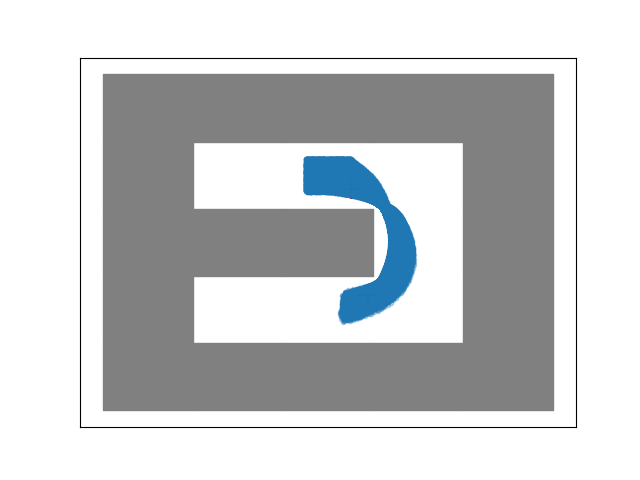

In [ ]:
pic_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]
plot_one_trajectory(load_data["observations"], traj_filepath="data.png", walls=np.array(pic_map))
Image(filename='data.png')

Обучение

In [ ]:
TRAIN_MAP = [
    [1, 1, 1, 1, 1],
    [1, 0, "r", 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, "g", 0, 1],
    [1, 1, 1, 1, 1],
]

config = ConfigBC(data_path="/content/data_umaze_good.hdf5",
                  total_timesteps=1000, eval_freq= int(1e2))
agent_BC = train(config, BCAgent, ReplayBuffer, train_offline, make_env)

SR,▁▁▁▁██▁▁▅▁▅▅▁
charts/SPS,▁▆▇▇█████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
losses/actor_loss,█▂▂▁▁▁▁▂▁▁▂▂▁
SR,0
charts/SPS,162
global_step,12000
losses/actor_loss,0.21231


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Checkpoints path: model
Dataset size: 500006
SPS: 0
Step 0: SR = 0.0
SPS: 21
Step 100: SR = 0.7
SPS: 29
Step 200: SR = 0.7
SPS: 36
Step 300: SR = 1.0
SPS: 42
Step 400: SR = 1.0
SPS: 47
Step 500: SR = 1.0
SPS: 51
Step 600: SR = 1.0
SPS: 54
Step 700: SR = 1.0
SPS: 56
Step 800: SR = 1.0
SPS: 58
Step 900: SR = 1.0


SR,▁▆▆███████
charts/SPS,▁▄▅▅▆▇▇███
global_step,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
losses/actor_loss,█▂▁▁▁▁▁▁▁▁
SR,1
charts/SPS,58
global_step,900
losses/actor_loss,0.05834


Оценка

SR: 1.0


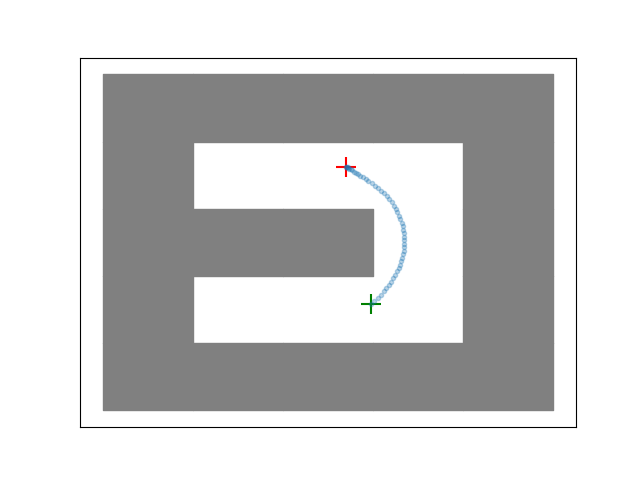

In [ ]:
pic_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

eval = Evaluate(make_env, EnvConfig())
eval.eval_tr(agent_BC)
Image(filename='output.png')

Загрузка весов эксперта. Эксперт - это агент, обученный с помощью метода SAC для конкретной карты. Может построить путь для любых начальных и целевых точек.

In [ ]:
env = make_env(1)()
observation_space_shape = env.observation_space.shape
action_space = env.action_space
device = torch.device(
        "cuda" if torch.cuda.is_available() and config.cuda else "cpu"
    )


config_expert = ConfigSAC()
expert_agent = SACAgent(config_expert, device, observation_space_shape, action_space)
expert_agent.load_state_dict(torch.load("/content/expert_Umaze.pt", map_location=device))

SR: 1.0


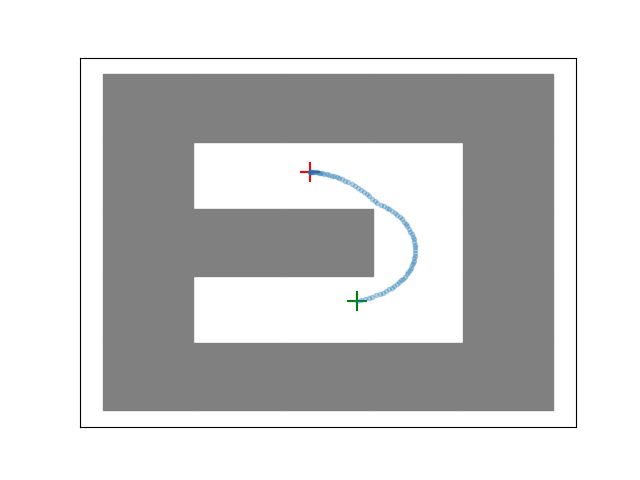

In [ ]:
eval.eval_tr(expert_agent)
Image(filename='output.png')